# Calling TYPHOON-OCR-7B on IBM watsonx.ai

In [176]:
import base64
from io import BytesIO
from PIL import Image
from ibm_watsonx_ai import APIClient
from ibm_watsonx_ai import Credentials
from ibm_watsonx_ai.foundation_models import ModelInference
import requests
from dotenv import load_dotenv
import os


In [332]:
load_dotenv()

# Configuration - Replace with your credentials
API_KEY = os.getenv("WX_AI_API_KEY")
DEPLOYMENT_ID = os.getenv("WX_AI_DEPLOYMENT_ID")  # The ID of your deployed Typhoon OCR model
URL = os.getenv("WX_AI_URL")  # Change based on your region

def get_iam_token(api_key):
    """Get IBM Cloud IAM token"""
    url = os.getenv("CLOUD_IAM_URL")
    headers = {"Content-Type": "application/x-www-form-urlencoded"}
    data = {
        "grant_type": "urn:ibm:params:oauth:grant-type:apikey",
        "apikey": api_key
    }
    response = requests.post(url, headers=headers, data=data)
    return response.json()["access_token"]

# Function to encode image to base64
def encode_image(image_path):
    """Encode image to base64 string"""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

# Get IAM token
print("Getting IAM token...")
iam_token = get_iam_token(API_KEY)
print("✓ Token received")


# Scoring endpoint URL - Using CHAT API for VLM models
scoring_url = f"{URL}/ml/v1/deployments/{DEPLOYMENT_ID}/text/chat?version=2024-03-19"

# Test OCR on a single image
print("\nTesting Typhoon OCR model...")
print("=" * 60)

# Encode your image
image_path = "/Users/pat/Desktop/custom_FM/images/Screenshot 2568-12-27 at 20.26.15.png"  # Replace with your image path
print(f"Reading image: {image_path}")
image_base64 = encode_image(image_path)
print("✓ Image encoded")

Getting IAM token...
✓ Token received

Testing Typhoon OCR model...
Reading image: /Users/pat/Desktop/custom_FM/images/Screenshot 2568-12-27 at 20.26.15.png
✓ Image encoded


In [ ]:
# You are a precise data extraction assistant. Extract tax invoice information from this Thai tax invoice/receipt document.

# CRITICAL INSTRUCTIONS:
# 1. Extract ONLY printed/typed text that is clearly visible and readable
# 2. IGNORE all handwritten text, signatures, stamps, and annotations
# 3. If a field is not present or unclear, use an empty string ""
# 4. Do NOT guess, infer, or fabricate any values
# 5. Preserve exact formatting for dates, numbers, and Thai text as they appear
# 6. For amounts: extract numbers only (no currency symbols, commas are acceptable)
# 7. For tax IDs: extract exactly 13 digits with no spaces or dashes

# FIELD DEFINITIONS:
# - invoice_number: The document/invoice number (often labeled "เลขที่" or "Invoice No.")
# - invoice_date: Date as printed (format: DD/MM/YYYY or as shown)
# - supplier_name_th: Seller's name in Thai (section labeled "ผู้ขาย" or "Seller"). Exclude branch designations like "(สำนักงานใหญ่)" or "(สาขา...)"
# - supplier_address_th: Seller's full address in Thai
# - supplier_tax_id: Seller's 13-digit tax identification number (เลขประจำตัวผู้เสียภาษี)
# - customer_name_th: Buyer's name in Thai (section labeled "ผู้ซื้อ" or "Buyer"). Exclude branch designations like "(สำนักงานใหญ่)" or "(สาขา...)"
# - customer_address_th: Buyer's full address in Thai
# - customer_tax_id: Buyer's 13-digit tax identification number
# - net_amount: Subtotal amount before VAT (มูลค่าสินค้า/บริการ)
# - total_tax_amount: VAT amount (ภาษีมูลค่าเพิ่ม 7%)
# - total_amount: Grand total including VAT (รวมทั้งสิ้น/Total/Grand Total/ยอดสุทธิ)
# - line_items: Array of products/services with description, quantity, unit_price, amount

# RESPONSE FORMAT:
# Return ONLY a valid JSON object with NO additional text, markdown formatting, code blocks, or explanations.

# JSON Structure:
# {
#   "invoice_number": "",
#   "invoice_date": "",
#   "supplier_name_th": "",
#   "supplier_address_th": "",
#   "supplier_tax_id": "",
#   "customer_name_th": "",
#   "customer_address_th": "",
#   "customer_tax_id": "",
#   "net_amount": "",
#   "total_tax_amount": "",
#   "total_amount": "",
#   "line_items": [
#     {
#       "description": "",
#       "quantity": "",
#       "unit_price": "",
#       "amount": ""
#     }
#   ]
# }

### prompt v0 (simple prompt)

In [259]:
# Prepare the request payload for chat API
payload = {
    "messages": [
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": "Please extract the exact text you see from this image."
                },
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/png;base64,{image_base64}"
                    }
                }
            ]
        }
    ],
    "parameters": {
        "max_tokens": 1500,
        "temperature": 0.1,
        "top_p": 0.8
    }
}

### prompt v1 (INOX prompt)

In [261]:
# Prepare the request payload for chat API
payload = {
    "messages": [
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": """ Please extract all the exact text from this image.
                                You are a precise data extraction assistant. Please extract all the exact text from this image. Extract tax invoice information from this Thai tax invoice/receipt document.
                                CRITICAL INSTRUCTIONS:
                                1. Extract ONLY printed/typed text that is clearly visible and readable
                                2. IGNORE all handwritten text, signatures, stamps, and annotations
                                3. If a field is not present or unclear, use an empty string ""
                                4. Do NOT guess, infer, or fabricate any values
                                5. Preserve exact formatting for dates, numbers, and Thai text as they appear
                                6. For amounts: extract numbers only (no currency symbols, commas are acceptable)
                                7. For tax IDs: extract exactly 13 digits with no spaces or dashes

                                FIELD DEFINITIONS:
                                - invoice_number: The document/invoice number (often labeled "Tax inv. No.", "No.", "Invoice No" or "เลขที่")
                                - invoice_date: Date as printed (format: DD/MM/YYYY or as shown)
                                - supplier_name_th: Seller's name in Thai (section labeled "ผู้ขาย" or "Seller"). Exclude branch designations like "(สำนักงานใหญ่)" or "(สาขา...)"
                                - supplier_address_th: Seller's full address in Thai
                                - supplier_tax_id: Seller's 13-digit tax identification number (เลขประจำตัวผู้เสียภาษี)
                                - customer_name_th: Buyer's name in Thai (section labeled "ผู้ซื้อ" or "Buyer"). Exclude branch designations like "(สำนักงานใหญ่)" or "(สาขา...)"
                                - customer_address_th: Buyer's full address in Thai
                                - customer_tax_id: Buyer's 13-digit tax identification number
                                - net_amount: Subtotal amount before VAT (มูลค่าสินค้า/บริการ)
                                - total_tax_amount: VAT amount (ภาษีมูลค่าเพิ่ม 7%)
                                - total_amount: Grand total including VAT (รวมทั้งสิ้น/Total/Grand Total/ยอดสุทธิ)
                                - line_items: Array of products/services with description, quantity, unit_price, amount

                                RESPONSE FORMAT:
                                Return ONLY a valid JSON object with NO additional text, markdown formatting, code blocks, or explanations.

                                JSON Structure:
                                {
                                "invoice_number": "",
                                "invoice_date": "",
                                "supplier_name_th": "",
                                "supplier_address_th": "",
                                "supplier_tax_id": "",
                                "customer_name_th": "",
                                "customer_address_th": "",
                                "customer_tax_id": "",
                                "net_amount": "",
                                "total_tax_amount": "",
                                "total_amount": "",
                                "line_items": [
                                    {
                                    "description": "",
                                    "quantity": "",
                                    "unit_price": "",
                                    "amount": ""
                                    }
                                ]
                            }
                    """
                },
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/png;base64,{image_base64}"
                    }
                }
            ]
        }
    ],
    "parameters": {
        "max_tokens": 1500,
        "temperature": 0.1,
        "top_p": 1.0
    }
}

### prompt v2 (Added system prompt)

In [333]:
# Prepare the request payload for chat API
payload = {
    "messages": [
        {
            "role": "system",
            "content": """
            You are an OCR extraction engine specialized in Thai and English financial documents.

            Your task is to extract ALL visible printed or typed text from the provided document image as accurately as possible.

            You must NOT summarize, interpret, translate, classify, or reformat the content.
            You must NOT infer missing text.
            You must NOT correct spelling or grammar.
            You must NOT guess unreadable characters.

            Your output must strictly reflect what is visually present in the document.
            """
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": """ Extract ALL visible text from this invoice / tax invoice document image.
                                CRITICAL INSTRUCTIONS:
                                1. Extract ONLY printed or typed text that is clearly visible.
                                2. IGNORE handwritten signatures, initials, stamps, checkmarks, or pen marks unless they are printed text.
                                3. Preserve original language exactly (Thai remains Thai, English remains English).
                                4. Preserve numbers, punctuation, spacing, and line breaks as they appear.
                                5. If a character or word is unclear, output it as "[UNREADABLE]".
                                6. Do NOT guess, infer, or auto-complete missing text.
                                7. Do NOT normalize formats (dates, amounts, tax IDs must remain exactly as printed).
                                8. Do NOT translate or explain anything.

                                LAYOUT & STRUCTURE RULES:
                                - Keep reading order top-to-bottom, left-to-right.
                                - Preserve section headers, boxes, and table rows in natural reading order.
                                - For tables:
                                - Keep each row on its own line.
                                - Keep column order as shown in the document.
                                - Keep repeated headers or footers if they appear.
                                - Keep duplicated text if it appears multiple times.

                                FIELD DEFINITIONS:
                                - invoice_number: The document/invoice number (often labeled "Tax inv. No.", "No.", "Invoice No" or "เลขที่")
                                - invoice_date: Date as printed (format: DD/MM/YYYY or as shown)
                                - supplier_name_th: Seller's name in Thai (section labeled "ผู้ขาย" or "Seller"). Exclude branch designations like "(สำนักงานใหญ่)" or "(สาขา...)"
                                - supplier_address_th: Seller's full address in Thai
                                - supplier_tax_id: Seller's 13-digit tax identification number (เลขประจำตัวผู้เสียภาษี)
                                - customer_name_th: Buyer's name in Thai (section labeled "ผู้ซื้อ" or "Buyer"). Exclude branch designations like "(สำนักงานใหญ่)" or "(สาขา...)"
                                - customer_address_th: Buyer's full address in Thai
                                - customer_tax_id: Buyer's 13-digit tax identification number
                                - net_amount: Subtotal amount before VAT (มูลค่าสินค้า/บริการ)
                                - total_tax_amount: VAT amount (ภาษีมูลค่าเพิ่ม 7%)
                                - total_amount: Grand total including VAT (รวมทั้งสิ้น/Total/Grand Total/ยอดสุทธิ)
                                - line_items: Array of products/services with description, quantity, unit_price, amount

                                RESPONSE FORMAT:
                                Return ONLY a valid JSON object with NO additional text, markdown formatting, code blocks, or explanations.

                                JSON Structure:
                                {
                                "invoice_number": "",
                                "invoice_date": "",
                                "supplier_name_th": "",
                                "supplier_address_th": "",
                                "supplier_tax_id": "",
                                "customer_name_th": "",
                                "customer_address_th": "",
                                "customer_tax_id": "",
                                "net_amount": "",
                                "total_tax_amount": "",
                                "total_amount": "",
                                "line_items": [
                                    {
                                    "description": "",
                                    "quantity": "",
                                    "unit_price": "",
                                    "amount": ""
                                    }
                                ]
                            }
                    """
                },
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/png;base64,{image_base64}"
                    }
                }
            ]
        }
    ],
    "parameters": {
        "max_tokens": 1500,
        "temperature": 0.1,
        "top_p": 1.0
    }
}

### OCR Result Real Usage


Calling Typhoon OCR model...
{"natural_text": "<logo>M-SEVEN</logo>\nM-SEVEN (THAILAND) CO.,LTD.\nบริษัท เอ็ม-เซเว่น (ประเทศไทย) จำกัด\n309, 311 ซอยอ่อนนุช 70/1 ถนนอ่อนนุช แขวงประเวศ เขตประเวศ กรุงเทพฯ 10250\n309, 311 SOI ONNUCH 70/1, ONNUCH RD., PRAVES, PRAVES, BANGKOK 10250\nโทร. 02-721-2222 (จังหวัดนนทบุรี 30 คน) แฟกซ์. 02-322-3963 Website : www.M-Seven.co.th\nใบแจ้งหนี้ / ใบวางบิล\nINVOICE\nเลขที่ผู้เสียภาษี 0105530029573\nM68/393\n\nลูกค้า บริษัท อินโนเวทีฟ เอ็กซ์ตรีมิตส์ จำกัด TAX ID:0105551117714 วันที่ 17 กันยายน 2568\nCLIENT DATE\nที่อยู่ 3 อาคารพร้อมพื้นที่ 3 ชั้นที่ 16 ห้องเลขที่ 1608-1614 ซอยลาดพร้าว 3 ถนนลาดพร้าว แขวงจอมพล เขตจตุจักร กรุงเทพฯ 10900\nADDRESS\n\n<table border=\"1\">\n<tr>\n    <th>รหัส CODE</th>\n    <th>รายการ DESCRIPTION</th>\n    <th>จำนวน QUANTITY</th>\n    <th>หน่วยละ PER UNIT</th>\n    <th>จำนวนเงิน AMOUNT</th>\n</tr>\n<tr>\n    <td>SV</td>\n    <td>ค่าบริการป้องกันและกำจัดมด แมลงสาบ</td>\n    <td></td>\n    <td></td>\n    <td>11,214.95</td>\n</tr>\n<
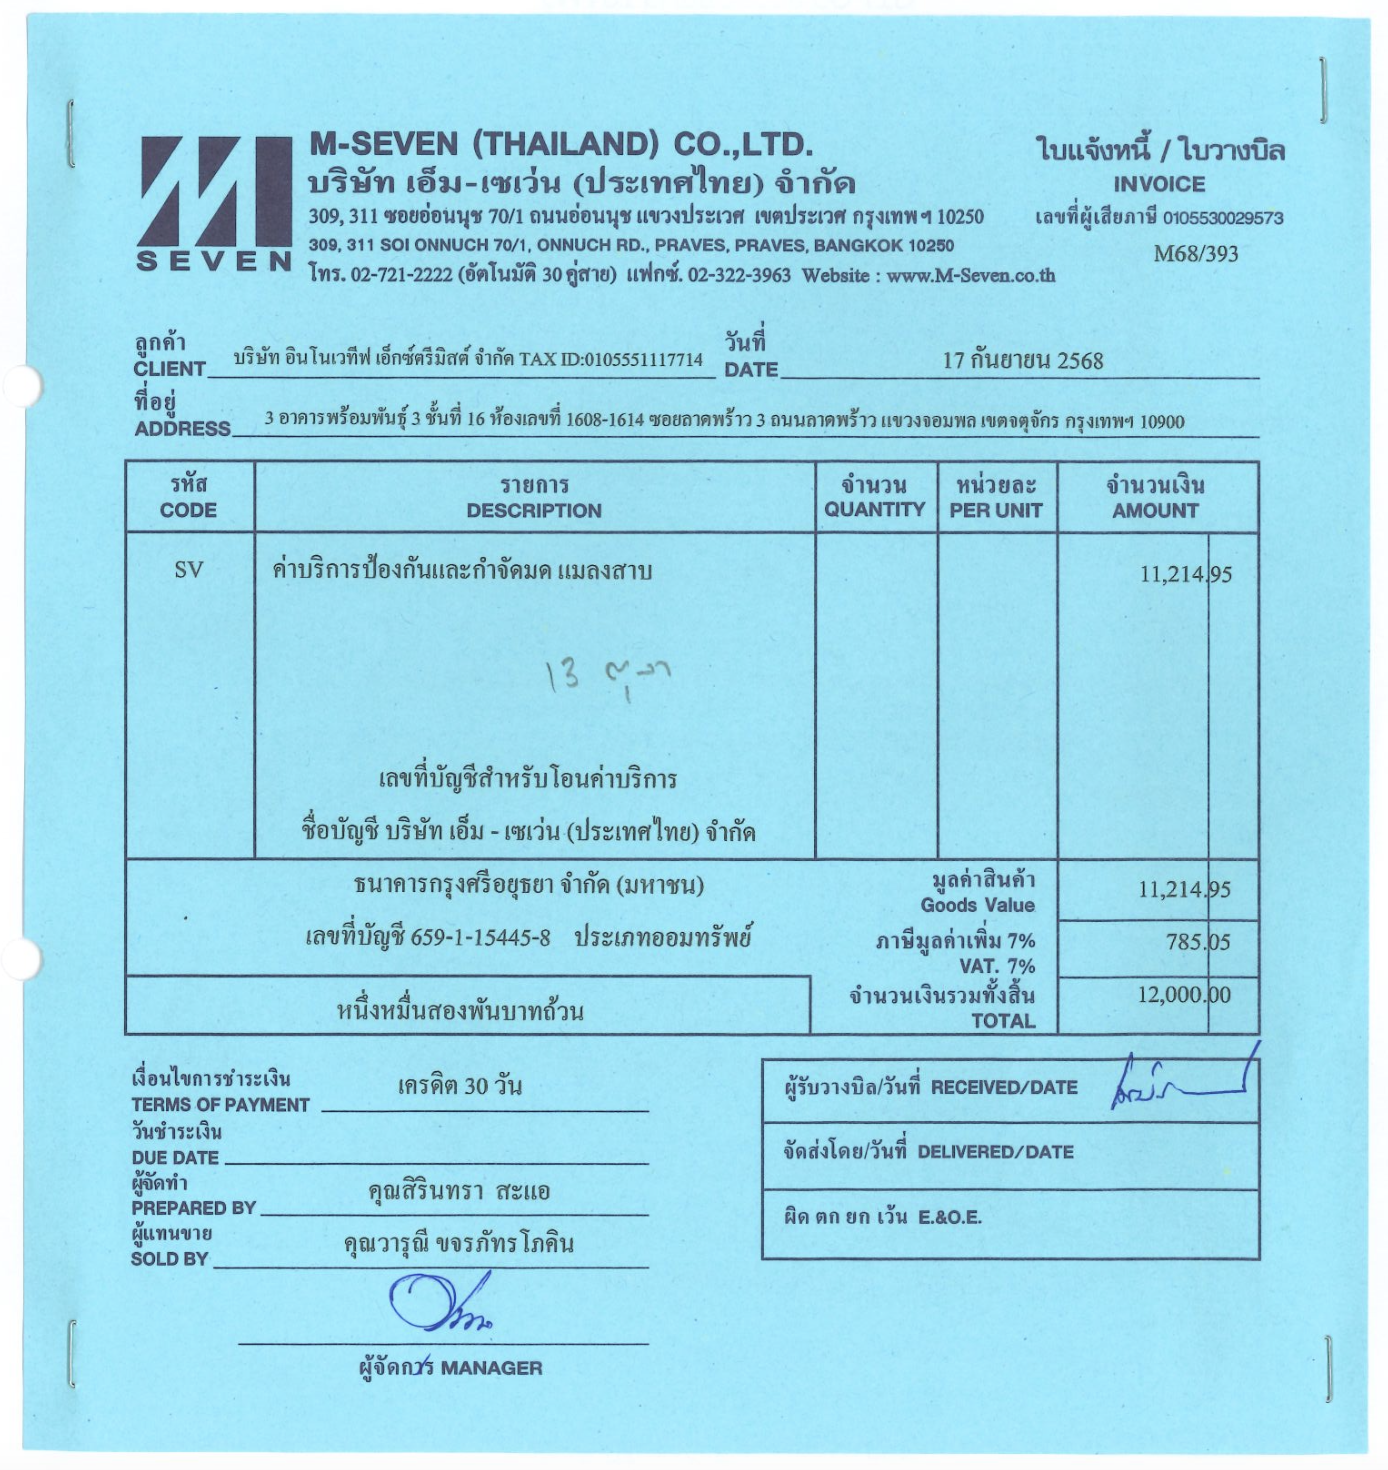

In [334]:
# Make the API request
print("\nCalling Typhoon OCR model...")
headers = {
    "Authorization": f"Bearer {iam_token}",
    "Content-Type": "application/json",
    "Accept": "application/json"
}
response = requests.post(scoring_url, headers=headers, json=payload)
if response.status_code == 200:
    result = response.json()
    extracted_text = result["choices"][0]["message"]["content"]
    print(extracted_text)
    print(payload)
else:
    print(f"Error: {response.status_code}")
    print(response.text)

# Calling GPT-OSS-120B on IBM watsonx.ai

In [335]:
# import os
from ibm_watsonx_ai import APIClient, Credentials
from ibm_watsonx_ai.foundation_models import ModelInference

# --- Configuration ---
API_KEY = os.getenv("WX_AI_API_KEY")
URL = os.getenv("WX_AI_URL")
PROJECT_ID = os.getenv("WX_AI_PROJECT_ID")

MODEL_ID = "openai/gpt-oss-120b"

credentials = Credentials(
    url=URL,
    api_key=API_KEY
)

client = APIClient(credentials)
client.set.default_project(PROJECT_ID)

print("✓ Client initialized and project set.")

✓ Client initialized and project set.


In [336]:
parameters = {
    "decoding_method": "greedy",
    "max_new_tokens": 1500,
    "repetition_penalty": 1.1,
    "reasoning_effort": "low" # Options: "low", "medium", "high"
}

model = ModelInference(
    model_id=MODEL_ID,
    params=parameters,
    credentials=credentials,
    project_id=PROJECT_ID
)

print(f"✓ Model {MODEL_ID} initialized with reasoning_effort='low'.")

✓ Model openai/gpt-oss-120b initialized with reasoning_effort='low'.


In [337]:
raw_text = extracted_text

prompt = f"""Extract information from the following text into valid JSON format.

  TEXT TO PROCESS:
  {raw_text}

  FIELD DEFINITIONS:
  - invoice_number: The document/invoice number (often labeled "Tax inv. No.", "No.", "Invoice No" or "เลขที่")
  - invoice_date: Date as printed (format: DD/MM/YYYY or as shown)
  - supplier_name_th: Seller's name in Thai (section labeled "ผู้ขาย" or "Seller"). Exclude branch designations like "(สำนักงานใหญ่)" or "(สาขา...)"
  - supplier_address_th: Seller's full address in Thai
  - supplier_tax_id: Seller's 13-digit tax identification number (เลขประจำตัวผู้เสียภาษี)
  - customer_name_th: Buyer's name in Thai (section labeled "ผู้ซื้อ" or "Buyer"). Exclude branch designations like "(สำนักงานใหญ่)" or "(สาขา...)"
  - customer_address_th: Buyer's full address in Thai
  - customer_tax_id: Buyer's 13-digit tax identification number
  - net_amount: Subtotal amount before VAT (มูลค่าสินค้า/บริการ)
  - total_tax_amount: VAT amount (ภาษีมูลค่าเพิ่ม 7%)
  - total_amount: Grand total including VAT (รวมทั้งสิ้น/Total/Grand Total/ยอดสุทธิ)
  - line_items: Array of products/services with description, quantity, unit_price, amount


  JSON Structure:
  {{
    "invoice_number": "",
    "invoice_date": "",
    "supplier_name_th": "",
    "supplier_address_th": "",
    "supplier_tax_id": "",
    "customer_name_th": "",
    "customer_address_th": "",
    "customer_tax_id": "",
    "net_amount": "",
    "total_tax_amount": "",
    "total_amount": "",
    "line_items": [
      {{
        "description": "",
        "quantity": "",
        "unit_price": "",
        "amount": ""
      }}
    ]
  }}

  CRITICAL: Return ONLY a valid JSON object. No explanation, no markdown blocks, no thinking process."""

messages = [
    {
        "role": "system",
        "content": "You are a precise information extraction assistant. You output raw JSON only."
    },
    {
        "role": "user",
        "content": prompt
    }
]

print(f"Calling model with Chat API (low reasoning effort)...\n")
response = model.chat(messages=messages)

print("--- Model Response ---")
if 'choices' in response:
    content = response['choices'][0]['message']['content']
    print(content)
else:
    print(response)

Calling model with Chat API (low reasoning effort)...



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/ibm_watsonx_ai/foundation_models/inference/base_model_inference.py:1177: UserWarning: Parameters [decoding_method, max_new_tokens, repetition_penalty] is/are not recognized and will be ignored.
  warn(invalid_params_warning)


--- Model Response ---
{
  "invoice_number": "M68/393",
  "invoice_date": "17/09/2568",
  "supplier_name_th": "บริษัท เอ็ม-เซเว่น (ประเทศไทย) จำกัด",
  "supplier_address_th": "309, 311 ซอยอ่อนนุช 70/1 ถนนอ่อนนุช แขวงประเวศ เขตประเวศ กรุงเทพฯ 10250",
  "supplier_tax_id": "0105530029573",
  "customer_name_th": "บริษัท อินโนเวทีฟ เอ็กซ์ตรีมิตส์ จำกัด",
  "customer_address_th": "ที่อยู่ 3 อาคารพร้อมพื้นที่ 3 ชั้นที่ 16 ห้องเลขที่ 1608-1614 ซอยลาดพร้าว 3 ถนนลาดพร้าว แขวงจอมพล เขตจตุจักร กรุงเทพฯ 10900",
  "customer_tax_id": "0105551117714",
  "net_amount": "11,214.95",
  "total_tax_amount": "785.05",
  "total_amount": "12,000.00",
  "line_items": [
    {
      "description": "ค่าบริการป้องกันและกำจัดมด แมลงสาบ",
      "quantity": "",
      "unit_price": "",
      "amount": "11,214.95"
    }
  ]
}


In [338]:
import json

data = json.loads(content)

print(data)
print(type(data)) 


{'invoice_number': 'M68/393', 'invoice_date': '17/09/2568', 'supplier_name_th': 'บริษัท เอ็ม-เซเว่น (ประเทศไทย) จำกัด', 'supplier_address_th': '309, 311 ซอยอ่อนนุช 70/1 ถนนอ่อนนุช แขวงประเวศ เขตประเวศ กรุงเทพฯ 10250', 'supplier_tax_id': '0105530029573', 'customer_name_th': 'บริษัท อินโนเวทีฟ เอ็กซ์ตรีมิตส์ จำกัด', 'customer_address_th': 'ที่อยู่ 3 อาคารพร้อมพื้นที่ 3 ชั้นที่ 16 ห้องเลขที่ 1608-1614 ซอยลาดพร้าว 3 ถนนลาดพร้าว แขวงจอมพล เขตจตุจักร กรุงเทพฯ 10900', 'customer_tax_id': '0105551117714', 'net_amount': '11,214.95', 'total_tax_amount': '785.05', 'total_amount': '12,000.00', 'line_items': [{'description': 'ค่าบริการป้องกันและกำจัดมด แมลงสาบ', 'quantity': '', 'unit_price': '', 'amount': '11,214.95'}]}
<class 'dict'>


In [339]:
import json

# Write JSON file
with open("/Users/pat/Desktop/custom_FM/working/comparison/result/updated_prompt_result/output_MSV-001_V2.json", "w", encoding="utf-8") as f:
    json.dump(
        data,
        f,
        ensure_ascii=False,  # keep Thai characters readable
        indent=2             # pretty print
    )

print("JSON file created")

JSON file created
